In [1]:
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.svm import SVR, SVC
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.stats import expon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
# color dict (use: colors['XColor'])

colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

# set params
# save as .mplstyle file and import with: plt.style.use('file')
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.color'] = 'r'

# colors for seaborn
dark = ["#8c510a", "#01665e", "#762a83"]
med = ["#d8b365", "#5ab4ac", "#af8dc3"]

# Make Predictions wrt Test Set

In [58]:
low_burn_test = '../pkl_trainsets/2jul2018/2jul2018_testset1_nucs_fissact_not-scaled.pkl'
train1 = '../pkl_trainsets/2jul2018/2jul2018_trainset1_nucs_fissact_not-scaled.pkl'
train2 = '../pkl_trainsets/2jul2018/2jul2018_trainset2_nucs_fissact_not-scaled.pkl'
train3 = '../pkl_trainsets/2jul2018/22jul2018_trainset3_nucs_fissact_not-scaled.pkl'
trainXY = pd.read_pickle(train3)
testXY = pd.read_pickle(train2)
testXY = testXY.sample(100)

In [59]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    if 'total' in dfX.columns:
        dfX.drop('total', axis=1, inplace=True)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    #o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY

trnX, rY, cY, eY, bY = splitXY(trainXY)
tstX, ry, cy, ey, by = splitXY(testXY)    #lowercase Y denotes testing labels

In [60]:
extra = []
for i in trnX.columns:
    if i not in tstX.columns:
        extra.append(i)
print(extra)
trnX = trnX.drop(extra, axis=1)
print(len(trnX.columns))
print(trnX.columns)
print(len(tstX.columns))
print(tstX.columns)

['te130']
46
Index(['ba138', 'ce140', 'ce142', 'ce144', 'cs133', 'cs135', 'cs137', 'la139',
       'mo100', 'mo95', 'mo97', 'mo98', 'nd143', 'nd144', 'nd145', 'nd146',
       'pd104', 'pd105', 'pd106', 'pr141', 'pu239', 'pu240', 'pu241', 'pu242',
       'rb87', 'rh103', 'ru101', 'ru102', 'ru104', 'sr88', 'sr90', 'tc99',
       'u234', 'u235', 'u236', 'u238', 'xe131', 'xe132', 'xe134', 'xe136',
       'y89', 'zr91', 'zr92', 'zr93', 'zr94', 'zr96'],
      dtype='object')
46
Index(['ba138', 'ce140', 'ce142', 'ce144', 'cs133', 'cs135', 'cs137', 'la139',
       'mo100', 'mo95', 'mo97', 'mo98', 'nd143', 'nd144', 'nd145', 'nd146',
       'pd104', 'pd105', 'pd106', 'pr141', 'pu239', 'pu240', 'pu241', 'pu242',
       'rb87', 'rh103', 'ru101', 'ru102', 'ru104', 'sr88', 'sr90', 'tc99',
       'u234', 'u235', 'u236', 'u238', 'xe131', 'xe132', 'xe134', 'xe136',
       'y89', 'zr91', 'zr92', 'zr93', 'zr94', 'zr96'],
      dtype='object')


In [61]:
#trainX = scale(trnX)
#testX = scale(tstX)
trainX = trnX
testX = tstX
trnX.shape

(24795, 46)

In [62]:
CV=5
for Y in ('r', 'b', 'c', 'e'):
    trainY = pd.Series()
    # get param names and set ground truth
    if Y == 'c':
        trainY = cY
        testY = cy
        parameter = 'cooling'
    elif Y == 'e': 
        trainY = eY
        testY = ey
        parameter = 'enrichment'
    elif Y == 'b':
        trainY = bY
        testY = by
        parameter = 'burnup'
    else:
        trainY = rY
        testY = ry
        parameter = 'reactor'    
    
    #######################
    # optimize parameters #
    #######################
            
    # initialize learners
    score = 'explained_variance'
    kfold = KFold(n_splits=CV, shuffle=True)
    knn_init = KNeighborsRegressor(n_neighbors=4, weights='distance')
    rr_init = Ridge(alpha=0.001)
    svr_init = SVR(gamma=0.001, C=200)
    if Y is 'r':
        score = 'accuracy'
        kfold = StratifiedKFold(n_splits=CV, shuffle=True)
        knn_init = KNeighborsClassifier(n_neighbors=4, weights='distance')
        rr_init = RidgeClassifier(alpha=0.001, class_weight='balanced')
        svr_init = SVC(gamma=0.001, C=200, class_weight='balanced')
    
    ########################
    # run predictions, etc #
    ########################
    
    knn_init.fit(trainX, trainY)
    rr_init.fit(trainX, trainY)
    svr_init.fit(trainX, trainY)
            
    scores = ['explained_variance', 'neg_mean_absolute_error']
    if Y is 'r':
        scores = ['accuracy', ]
        
    kpred = knn_init.predict(testX)
    kscr = knn_init.score(testX, testY)
    rpred = rr_init.predict(testX)
    rscr = rr_init.score(testX, testY)
    spred = svr_init.predict(testX)
    sscr = svr_init.score(testX, testY)
    
    print('The {} scores are knn={}, rr={}, and svr={}\n'.format(parameter, kscr, rscr, sscr), flush=True)
    preds_by_alg = pd.DataFrame({'TrueY': testY, 'kNN': kpred, 
                                 'Ridge': rpred, 'SVR': spred}, 
                                 index=testY.index)
    preds_by_alg.to_csv('testset2_v_trainset3_' + parameter + '_predictions.csv')

The reactor scores are knn=0.71, rr=0.85, and svr=0.97

The burnup scores are knn=0.9919038725237824, rr=0.9985980485091919, and svr=0.999480656297587

The cooling scores are knn=0.6683540811651878, rr=0.736215588852533, and svr=0.8508167973071743

The enrichment scores are knn=0.6670482693234943, rr=0.7953683553671357, and svr=0.8322638461382159



## SFCOMPO data set

In [3]:
# predictions
rxtr = pd.read_csv('../results/22jul2018/testing_set_preds/testset3_v_trainset2_reactor_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# MWd/MTU
burn = pd.read_csv('../results/22jul2018/testing_set_preds/testset3_v_trainset2_burnup_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# %u235
enri = pd.read_csv('../results/22jul2018/testing_set_preds/testset3_v_trainset2_enrichment_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# days
cool = pd.read_csv('../results/22jul2018/testing_set_preds/testset3_v_trainset2_cooling_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})

Y = 'TrueY'
knn = 'kNN'
rr = 'Ridge'
svr = 'SVR'

In [4]:
enri.head()

,Instance,Ridge,SVR,TrueY,kNN
0,4.270e+03,14.388673,7.632205,2.07,4.0
1,1.097e+03,9.229891,1.853274,0.52,1.5
2,6.438e+02,1.812038,2.335735,2.12,3.0
3,1.715e+03,17.363428,8.109452,3.03,4.0
4,2.311e+02,4.947231,2.454611,2.79,1.5


In [5]:
burn = burn.filter(items=[knn, rr, svr, Y])//1000
cool = cool.filter(items=[knn, rr, svr, Y])//30
enri = enri.filter(items=[knn, rr, svr, Y])

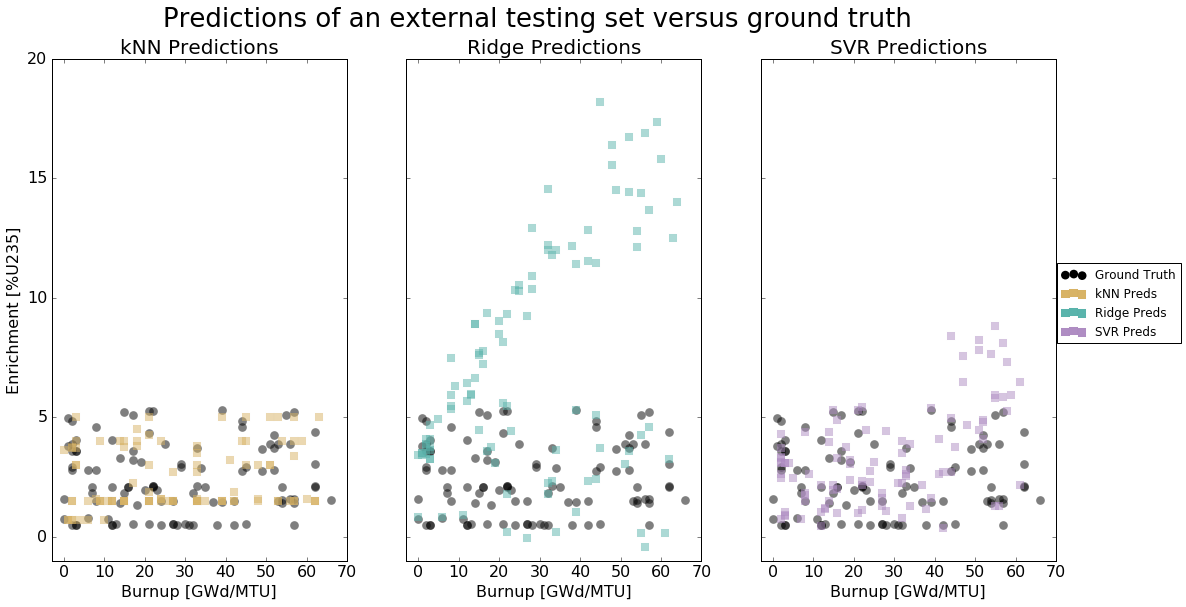

In [7]:
fig.clf()

fig, (ax_knn, ax_rr, ax_svr) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,9))
plt.xlim(-3, 70)
plt.ylim(-1, 20)
ax_knn.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_rr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_svr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_knn.set_ylabel('Enrichment [%U235]', fontsize=16)

ax_knn.tick_params(labelsize=16)
ax_rr.tick_params(labelsize=16)
ax_svr.tick_params(labelsize=16)

# GROUND TRUTHS
l0 = ax_knn.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_rr.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_svr.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')

# PREDICTIONS
l1 = ax_knn.scatter(burn[[knn]], enri[[knn]], c=colors['MBrwn'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='kNN Pred')
l2 = ax_rr.scatter(burn[[rr]], enri[[rr]], c=colors['MTeal'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='Ridge Pred')
l3 = ax_svr.scatter(burn[[svr]], enri[[svr]], c=colors['MPurp'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='SVR Pred')

ax_knn.set_title('kNN Predictions', fontsize=20)
ax_rr.set_title('Ridge Predictions', fontsize=20)
ax_svr.set_title('SVR Predictions', fontsize=20)
plt.suptitle('Predictions of an external testing set versus ground truth', fontsize=26)
leg = fig.legend((l0, l1, l2, l3), ('Ground Truth', 'kNN Preds', 'Ridge Preds', 'SVR Preds'), loc=7)
for l in leg.legendHandles: l.set_alpha(1)
fig.savefig('../results/22jul2018/graphs/testset3_v_trainset2.png', bbox_inches='tight', transparent=True)
plt.show()

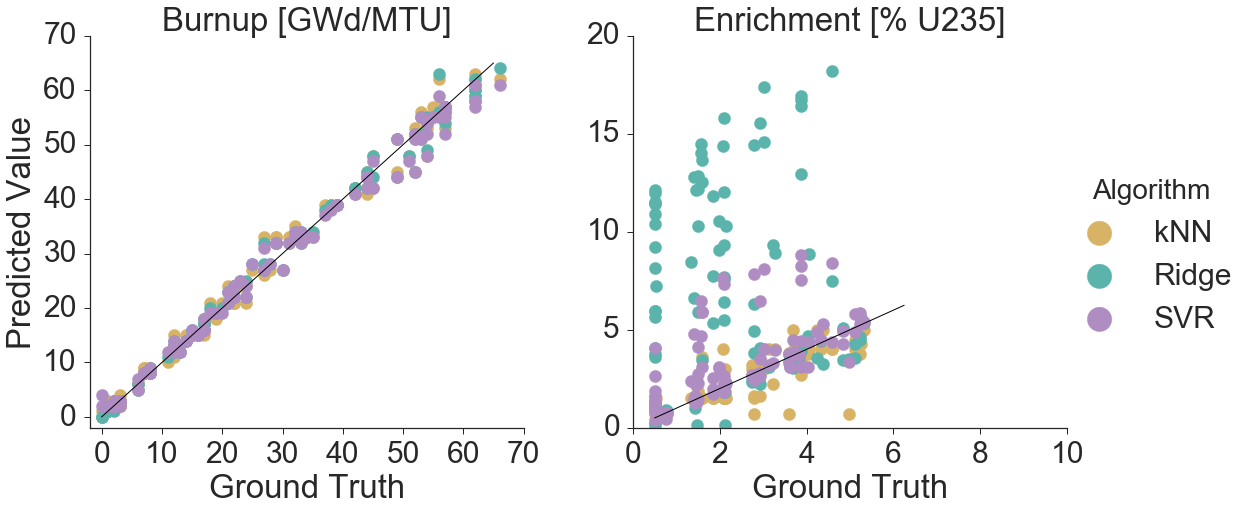

In [15]:
plt.clf()
sns.set(style="ticks", font_scale=3.0)

burn['Parameter'] = 'Burnup [GWd/MTU]'
enri['Parameter'] = 'Enrichment [% U235]'
cool['Parameter'] = 'Cooling Time [Months]'

pred_df = pd.DataFrame()
pred_df = pd.concat([burn, enri])#, cool])
pred_df = pred_df.melt(id_vars = ['TrueY', 'Parameter'], 
                       value_vars = ['kNN', 'Ridge', 'SVR'], 
                       value_name='Predicted Value', var_name='Algorithm')
pred = sns.FacetGrid(data=pred_df, col="Parameter",
                     hue="Algorithm", 
                     sharex=False, sharey=False, size=8, 
                     palette=sns.color_palette(med))
pred= pred.map(plt.scatter, 'TrueY', 'Predicted Value', s=150)

(pred.set_axis_labels("Ground Truth", "Predicted Value")
     .set_titles("{col_name}")
     .add_legend(markerscale=2))
pred.axes[0,0].set_ylim(-2, 70)
pred.axes[0,0].set_xlim(-2, 70)
pred.axes[0,0].plot([0, 65], [0, 65], 'k-', linewidth=1)
pred.axes[0,1].set_ylim(0, 20)
pred.axes[0,1].set_xlim(0, 10)
pred.axes[0,1].plot([0.5, 6.25], [0.5, 6.25], 'k-', linewidth=1)
#pred.axes[0,2].set_ylim(-20, 90)
#pred.axes[0,2].set_xlim(-20, 90)
#pred.axes[0,2].plot([-20, 90], [-20, 90], 'k-', linewidth=1)

pred.savefig('../results/22jul2018/graphs/trainset2_preds_v_testset3_trueY-detailed.png', bbox_inches='tight', transparent=True)

## Training Set #3

In [9]:
# predictions
rxtr = pd.read_csv('../results/22jul2018/testing_set_preds/testset2_v_trainset3_reactor_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# MWd/MTU
burn = pd.read_csv('../results/22jul2018/testing_set_preds/testset2_v_trainset3_burnup_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# %u235
enri = pd.read_csv('../results/22jul2018/testing_set_preds/testset2_v_trainset3_enrichment_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# days
cool = pd.read_csv('../results/22jul2018/testing_set_preds/testset2_v_trainset3_cooling_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})

burn = burn.filter(items=[knn, rr, svr, Y])//1000
cool = cool.filter(items=[knn, rr, svr, Y])//30
enri = enri.filter(items=[knn, rr, svr, Y])

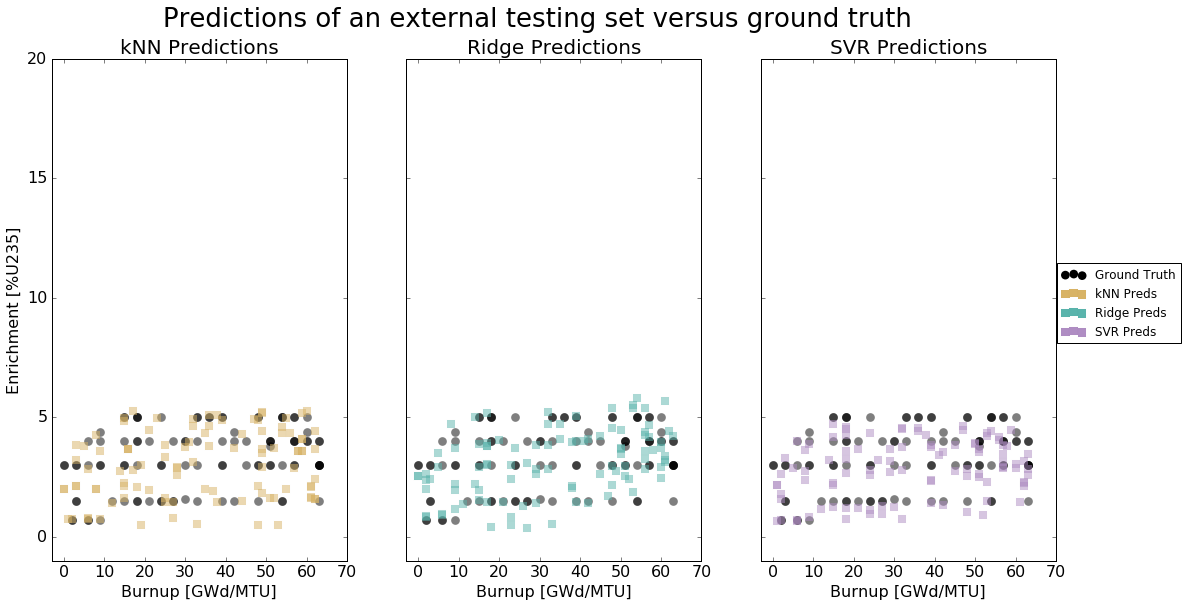

In [10]:
fig.clf()

fig, (ax_knn, ax_rr, ax_svr) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,9))
plt.xlim(-3, 70)
plt.ylim(-1, 20)
ax_knn.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_rr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_svr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_knn.set_ylabel('Enrichment [%U235]', fontsize=16)

ax_knn.tick_params(labelsize=16)
ax_rr.tick_params(labelsize=16)
ax_svr.tick_params(labelsize=16)

# GROUND TRUTHS
l0 = ax_knn.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_rr.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_svr.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')

# PREDICTIONS
l1 = ax_knn.scatter(burn[[knn]], enri[[knn]], c=colors['MBrwn'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='kNN Pred')
l2 = ax_rr.scatter(burn[[rr]], enri[[rr]], c=colors['MTeal'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='Ridge Pred')
l3 = ax_svr.scatter(burn[[svr]], enri[[svr]], c=colors['MPurp'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='SVR Pred')

ax_knn.set_title('kNN Predictions', fontsize=20)
ax_rr.set_title('Ridge Predictions', fontsize=20)
ax_svr.set_title('SVR Predictions', fontsize=20)
plt.suptitle('Predictions of an external testing set versus ground truth', fontsize=26)
leg = fig.legend((l0, l1, l2, l3), ('Ground Truth', 'kNN Preds', 'Ridge Preds', 'SVR Preds'), loc=7)
for l in leg.legendHandles: l.set_alpha(1)
fig.savefig('../results/22jul2018/graphs/testset2_v_trainset3.png', bbox_inches='tight', transparent=True)
plt.show()

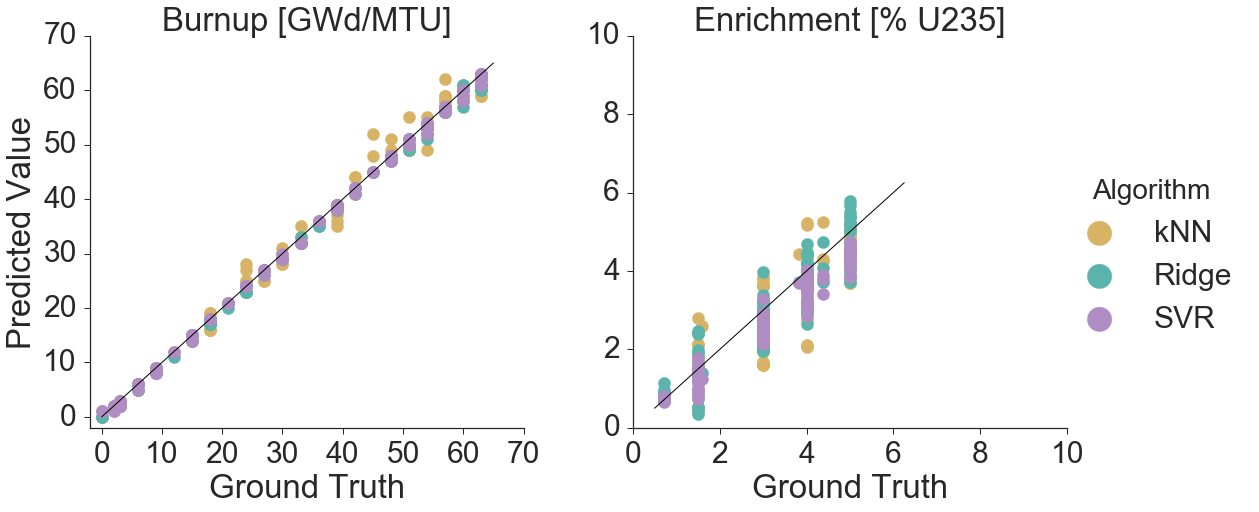

In [11]:
plt.clf()
sns.set(style="ticks", font_scale=3.0)

burn['Parameter'] = 'Burnup [GWd/MTU]'
enri['Parameter'] = 'Enrichment [% U235]'
cool['Parameter'] = 'Cooling Time [Months]'

pred_df = pd.DataFrame()
pred_df = pd.concat([burn, enri])#, cool])
pred_df = pred_df.melt(id_vars = ['TrueY', 'Parameter'], 
                       value_vars = ['kNN', 'Ridge', 'SVR'], 
                       value_name='Predicted Value', var_name='Algorithm')
pred = sns.FacetGrid(data=pred_df, col="Parameter",
                     hue="Algorithm", 
                     sharex=False, sharey=False, size=8, 
                     palette=sns.color_palette(med))
pred= pred.map(plt.scatter, 'TrueY', 'Predicted Value', s=150)

(pred.set_axis_labels("Ground Truth", "Predicted Value")
     .set_titles("{col_name}")
     .add_legend(markerscale=2))
pred.axes[0,0].set_ylim(-2, 70)
pred.axes[0,0].set_xlim(-2, 70)
pred.axes[0,0].plot([0, 65], [0, 65], 'k-', linewidth=1)
pred.axes[0,1].set_ylim(0, 10)
pred.axes[0,1].set_xlim(0, 10)
pred.axes[0,1].plot([0.5, 6.25], [0.5, 6.25], 'k-', linewidth=1)
#pred.axes[0,2].set_ylim(-20, 90)
#pred.axes[0,2].set_xlim(-20, 90)
#pred.axes[0,2].plot([-20, 90], [-20, 90], 'k-', linewidth=1)

pred.savefig('../results/22jul2018/graphs/trainset3_preds_v_testset2_trueY-detailed.png', bbox_inches='tight', transparent=True)

In [ ]:
## Code from hyperparam optimization

CV=5
for Y in ('r', 'b', 'c', 'e'):
    trainY = pd.Series()
    # get param names and set ground truth
    if Y == 'c':
        trainY = cY
        testY = cy
        parameter = 'cooling'
    elif Y == 'e': 
        trainY = eY
        testY = ey
        parameter = 'enrichment'
    elif Y == 'b':
        trainY = bY
        testY = by
        parameter = 'burnup'
    else:
        trainY = rY
        testY = ry
        parameter = 'reactor'
            
    #######################
    # optimize parameters #
    #######################
            
    # initialize learners
    score = 'explained_variance'
    kfold = KFold(n_splits=CV, shuffle=True)
    knn_init = KNeighborsRegressor(weights='distance')
    rr_init = Ridge()
    svr_init = SVR()
    if Y is 'r':
        score = 'accuracy'
        kfold = StratifiedKFold(n_splits=CV, shuffle=True)
        knn_init = KNeighborsClassifier(weights='distance')
        rr_init = RidgeClassifier(class_weight='balanced')
        svr_init = SVC(class_weight='balanced')
            
    # CV search the hyperparams
    knn_grid = {'n_neighbors': np.linspace(1, 50).astype(int)}
    rr_grid = {'alpha': np.logspace(-4, 10)} 
    svr_grid = {'C': expon(scale=100), 'gamma': expon(scale=.1)}
    knn_opt = RandomizedSearchCV(estimator=knn_init, param_distributions=knn_grid, 
                                 n_iter=20, scoring=score, n_jobs=-1, cv=kfold, 
                                 return_train_score=True)
    rr_opt = RandomizedSearchCV(estimator=rr_init, param_distributions=rr_grid,
                                n_iter=20, scoring=score, n_jobs=-1, cv=kfold, 
                                return_train_score=True)
    svr_opt = RandomizedSearchCV(estimator=svr_init, param_distributions=svr_grid,
                                 n_iter=20, scoring=score, n_jobs=-1, cv=kfold, 
                                 return_train_score=True)
    knn_opt.fit(trainX, trainY)
    rr_opt.fit(trainX, trainY)
    svr_opt.fit(trainX, trainY)

    ## Get best params
    k = knn_opt.best_params_['n_neighbors']
    a = rr_opt.best_params_['alpha']
    g = svr_opt.best_params_['gamma']
    c = svr_opt.best_params_['C']
    print('The {} prediction`s best params are k={}, alpha={}, gamma={}, and C={}\n'.format(parameter, k, a, g, c), flush=True)
    
    # gather optimized learners
    knn = knn_opt.best_estimator_
    rr = rr_opt.best_estimator_
    svr = svr_opt.best_estimator_

